Set `autoreload` to execute the change in `.py` files.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import _pickle
from pathlib import Path
import gc
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from __utils__ import image_processing
from __utils__ import label_processing
from __utils__ import labeling
from __utils__ import loso_preparing
from __utils__ import spotting

In [3]:
dataset_dir = "D:/Databases/CAS(ME)^2"
# dataset_dir = "F:/HEH/Databases/CAS(ME)^2"
# dataset_dir = "/data/disk1/heh/databases/CAS(ME)^2"

test_dataset_dir = "D:/Databases/MEGC2022_testSet/CAS_Test_cropped"
# test_dataset_dir = "F:/HEH/Databases/MEGC2022_testSet/CAS_Test_cropped"
# test_dataset_dir = "/data/disk1/heh/databases/MEGC2022_testSet/CAS_Test_cropped"

images_loading = False
image_size = 128
load_cropped_images = False
# expression_type = "mae"  # macro-expression spotting
expression_type = "me"  # micro-expression spotting
debug_preds = True
labeling_function = "pseudo_labeling"
# labeling_function = "original_labeling"
model_names = {
    0: "SOFTNet",
    1: "SOFTNetCBAM",
    2: "ViT-B",
    3: "SL-ViT-B",
    4: "Swin-T",
    5: "Swin-S",
    6: "L-Swin-T",
    7: "S-Swin-T",
    8: "SL-Swin-T",
    9: "SL-Swin-S",
}
model_name = model_names[8]
batch_size = 48
epochs = 25
save_preds = False
test_preds_parent = Path(test_dataset_dir).parent / Path(
    Path(test_dataset_dir).name.split("_")[0]
    + "_"
    + Path(test_dataset_dir).name.split("_")[1],
    "preds",
)
test_preds_stem = (
    f"{expression_type}_"
    + model_name.lower().replace("-", "_")
    + f"_batch_size_{batch_size}"
    + f"_epochs_{epochs}"
    + f"_{labeling_function}"
    # + f"_0_005"
    # + f"_adam"
    + f"_{image_size}"
)
test_preds_path = Path(test_preds_parent, test_preds_stem).with_suffix(".pkl")
print(f"test_preds_path: {test_preds_path}")

test_preds_path: D:\Databases\MEGC2022_testSet\CAS_Test\preds\me_sl_swin_t_batch_size_48_epochs_25_pseudo_labeling_128.pkl


## Load Training Images


When debug the image processing, the videos_images is from cropped_rawpic, whereas the other variables are from rawpic.


In [4]:
videos_images, subjects, subjects_videos_code = image_processing.load_images(
    dataset_dir,
    images_loading=images_loading,
    image_size=image_size,
    load_cropped_images=load_cropped_images,
)

subject:  s15
subject:  s16
subject:  s19
subject:  s20
subject:  s21
subject:  s22
subject:  s23
subject:  s24
subject:  s25
subject:  s26
subject:  s27
subject:  s29
subject:  s30
subject:  s31
subject:  s32
subject:  s33
subject:  s34
subject:  s35
subject:  s36
subject:  s37
subject:  s38
subject:  s40


In [5]:
print("subjects:", subjects)
print("subjects_videos_code:", subjects_videos_code)

subjects: ['s15', 's16', 's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27', 's29', 's30', 's31', 's32', 's33', 's34', 's35', 's36', 's37', 's38', 's40']
subjects_videos_code: [['0101', '0102', '0401', '0402', '0502', '0503', '0505', '0508'], ['0101', '0102', '0401', '0402', '0502', '0505', '0507'], ['0102', '0402', '0505', '0507', '0502'], ['0502'], ['0101', '0401'], ['0101', '0102', '0402', '0503', '0508'], ['0102', '0402', '0503', '0507'], ['0101', '0401', '0402', '0502', '0507'], ['0101', '0102', '0502', '0508'], ['0101', '0102', '0401', '0503'], ['0101', '0102', '0401', '0402', '0502', '0503', '0505', '0507', '0508'], ['0502'], ['0101', '0102', '0401', '0502', '0503', '0505', '0507'], ['0101', '0401', '0402', '0502', '0503', '0505', '0507'], ['0101', '0102', '0401', '0402', '0502', '0503', '0505', '0507', '0508'], ['0102', '0402'], ['0401', '0402', '0503'], ['0102'], ['0401', '0505'], ['0101', '0402', '0502', '0505', '0507', '0508'], ['0502', '0507'], ['0401', '0502', '

## Load Test Images


In [6]:
test_videos_images, test_subjects, test_videos_name = image_processing.load_images(
    test_dataset_dir, images_loading=images_loading, image_size=image_size
)

test_subject_video_code:  sub01
test_subject_video_code:  sub02
test_subject_video_code:  sub03
test_subject_video_code:  sub04
test_subject_video_code:  sub05


In [7]:
print("test_subjects:", test_subjects)
print("test_videos_name:", test_videos_name)

test_subjects: ['sub01', 'sub02', 'sub03', 'sub04', 'sub05']
test_videos_name: ['sub01', 'sub02', 'sub03', 'sub04', 'sub05']


## Load Excel 


In [8]:
Excel_data = label_processing.load_excel(dataset_dir)
Excel_data.head(5)

,participant,video_name_&_expression_number,onset,apex,offset,AUs,extimated_emotion,expression_type,self-reported_emotion,video_name,video_code,subject
0,1,anger1_1,557,572,608,4+10+14+15,negative,macro-expression,anger,anger1,0401,s15
1,1,anger1_2,2854,2862,2871,38,others,macro-expression,sadness,anger1,0401,s15
2,1,anger2_1,2155,2163,0,NaN,negative,macro-expression,anger,anger2,0402,s15
3,1,anger2_2,3363,3371,3383,4+7+14,negative,macro-expression,anger,anger2,0402,s15
4,1,anger2_3,3380,3386,3407,4+14+38,negative,macro-expression,anger,anger2,0402,s15


## Load Ground Truth Labels


In [9]:
(
    clean_videos_images,
    clean_subjects_videos_code,
    clean_subjects,
    clean_subjects_videos_ground_truth_labels,
) = label_processing.load_ground_truth_labels(
    dataset_dir,
    expression_type,
    videos_images,
    subjects_videos_code,
    subjects,
    Excel_data,
)

required_videos_index:  [1, 4, 8, 9, 12, 13, 14, 16, 28, 33, 36, 37, 38, 45, 46, 47, 49, 50, 52, 54, 55, 57, 62, 64, 67, 71, 73, 74, 77, 83, 87, 91, 93]
len(clean_videos_images) = 33


In [10]:
print("len(clean_subjects): ", len(clean_subjects))
print("clean_subjects: ", clean_subjects)
print("len(clean_subjects_videos_code): ", len(clean_subjects_videos_code))
print("clean_subjects_videos_codes: ", clean_subjects_videos_code)
print(
    "len(clean_subjects_videos_ground_truth_labels): ",
    len(clean_subjects_videos_ground_truth_labels),
)

# 7 (s23) has happy1 (0502) in excel but the folder name is happy2 (0503)
print(
    "clean_subjects_videos_ground_truth_labels[6]: ",
    clean_subjects_videos_ground_truth_labels[6],
)

len(clean_subjects):  14
clean_subjects:  ['s15' 's16' 's19' 's23' 's24' 's25' 's27' 's29' 's30' 's31' 's32' 's35'
 's37' 's38']
len(clean_subjects_videos_code):  14
clean_subjects_videos_codes:  [['0102', '0502'], ['0101', '0102', '0502', '0505', '0507'], ['0402'], ['0102'], ['0401', '0507'], ['0101', '0102'], ['0101', '0102', '0401', '0502', '0503', '0507'], ['0502'], ['0101', '0401'], ['0101', '0402', '0505'], ['0401', '0502', '0503', '0508'], ['0102'], ['0402', '0508'], ['0507']]
len(clean_subjects_videos_ground_truth_labels):  14
clean_subjects_videos_ground_truth_labels[6]:  [[[873, 887]], [[33, 47], [308, 316], [373, 387]], [[351, 364], [368, 381], [1134, 1146], [1973, 1985]], [[612, 627]], [[418, 431]], [[875, 889]]]


In [11]:
total_len = 0
for index, clean_subject_videos_code in enumerate(clean_subjects_videos_code):
    ground_truth_len = 0
    for i in clean_subjects_videos_ground_truth_labels[index]:
        for j in i:
            ground_truth_len += 1
    print(
        f"{index} {clean_subjects[index]}: {clean_subject_videos_code}, ground truth len: {ground_truth_len}"
    )
    total_len += ground_truth_len
print("total len: ", total_len)

0 s15: ['0102', '0502'], ground truth len: 2
1 s16: ['0101', '0102', '0502', '0505', '0507'], ground truth len: 8
2 s19: ['0402'], ground truth len: 1
3 s23: ['0102'], ground truth len: 3
4 s24: ['0401', '0507'], ground truth len: 8
5 s25: ['0101', '0102'], ground truth len: 4
6 s27: ['0101', '0102', '0401', '0502', '0503', '0507'], ground truth len: 11
7 s29: ['0502'], ground truth len: 1
8 s30: ['0101', '0401'], ground truth len: 2
9 s31: ['0101', '0402', '0505'], ground truth len: 6
10 s32: ['0401', '0502', '0503', '0508'], ground truth len: 6
11 s35: ['0102'], ground truth len: 2
12 s37: ['0402', '0508'], ground truth len: 2
13 s38: ['0507'], ground truth len: 1
total len:  57


## Calculate `k`


In [12]:
k = label_processing.calculate_k(clean_subjects_videos_ground_truth_labels)

k (Half of average length of expression) =  6


### Load Resampled Clean Videos Images Features


In [13]:
if debug_preds is False:
    with open(
        Path(
            dataset_dir,
            f"resampled_clean_videos_images_{expression_type}_features_{image_size}",
        ).with_suffix(".pkl"),
        "rb",
    ) as pkl_file:
        resampled_clean_videos_images_features = _pickle.load(pkl_file)
        pkl_file.close()

In [14]:
if debug_preds is not True:
    print(
        "len(resampled_clean_videos_images_features): ",
        len(resampled_clean_videos_images_features),
    )
    print(
        "len(resampled_clean_videos_images_features[0]): ",
        len(resampled_clean_videos_images_features[0]),
    )
    print(
        "resampled_clean_videos_images_features[0][0].shape: ",
        resampled_clean_videos_images_features[0][0].shape,
    )

## Labeling


In [15]:
if debug_preds is False:
    if labeling_function == "pseudo_labeling":
        labels = labeling.get_pseudo_labels(
            clean_videos_images, clean_subjects_videos_ground_truth_labels, k
        )
    elif labeling_function == "original_labeling":
        labels = labeling.get_original_labels(
            clean_videos_images, clean_subjects_videos_ground_truth_labels, k
        )

## Prepare for LOSO


In [16]:
if debug_preds is False:
    X, y, groups = loso_preparing.legacy_prepare_for_loso(
        resampled_clean_videos_images_features,
        labels,
        clean_subjects,
        clean_videos_images,
        clean_subjects_videos_ground_truth_labels,
        k,
    )

In [17]:
if debug_preds is False:
    del resampled_clean_videos_images_features
    gc.collect()

## Training


In [18]:
if debug_preds is False:
    from __utils__.training_test import train_and_test

    preds = train_and_test(
        X=X,
        image_size=image_size,
        y=y,
        test_dataset_dir=test_dataset_dir,
        test_videos_name=test_videos_name,
        expression_type=expression_type,
        model_name=model_name,
        train_or_not=True,
        batch_size=batch_size,
        epochs=epochs,
    )
else:
    with open(test_preds_path, "rb") as pkl_file:
        preds = _pickle.load(pkl_file)
        pkl_file.close()

In [19]:
if save_preds is True:
    with open(test_preds_path, "wb") as pkl_file:
        _pickle.dump(preds, pkl_file)
        pkl_file.close()

## Spotting


test video 1/5 is in process.


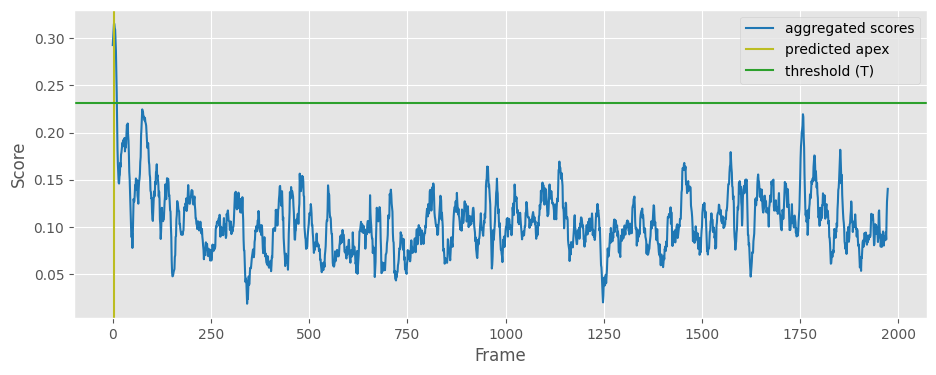

The current test video be processed: sub01
test video 1/5 is processed.

test video 2/5 is in process.


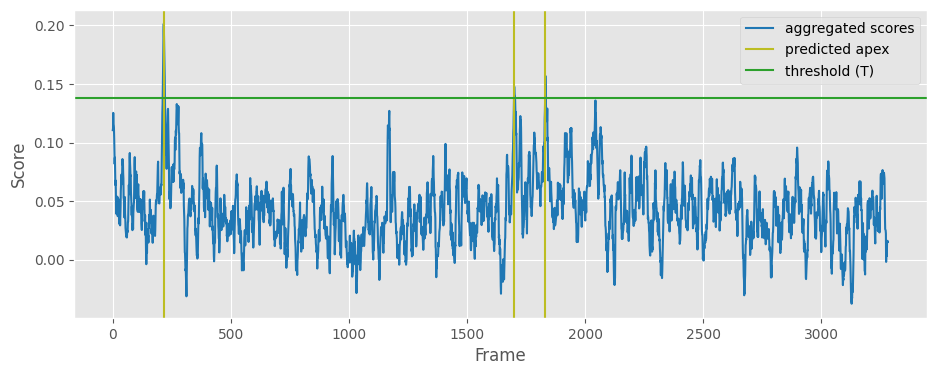

The current test video be processed: sub02
test video 2/5 is processed.

test video 3/5 is in process.


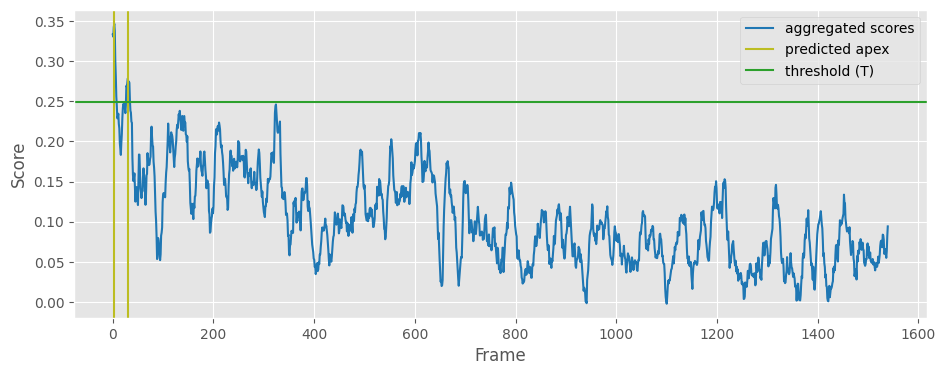

The current test video be processed: sub03
test video 3/5 is processed.

test video 4/5 is in process.


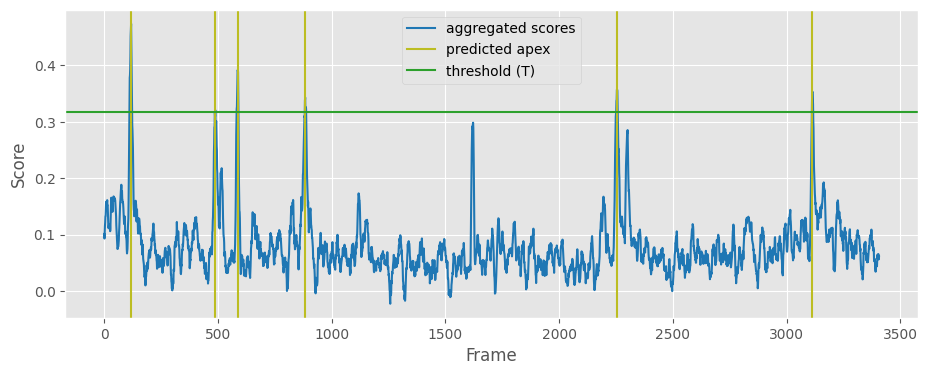

The current test video be processed: sub04
test video 4/5 is processed.

test video 5/5 is in process.


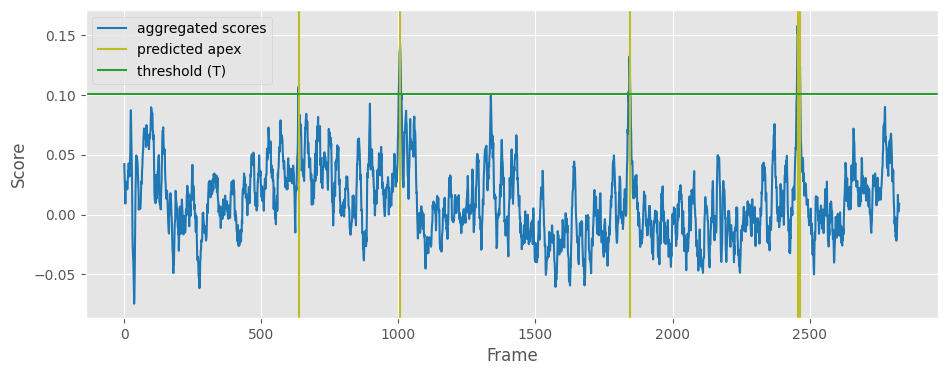

The current test video be processed: sub05
test video 5/5 is processed.



In [20]:
test_videos_preds = spotting.spot_test(
    preds=preds, k=k, p=0.60, test_videos_name=test_videos_name, show_plot_or_not=True
)

In [21]:
# # print for csv submission
# print("vid,pred_onset,pred_offset,type")
for test_video_name, test_video_preds in zip(test_videos_name, test_videos_preds):
    if len(test_video_preds) != 0:
        for test_video_pred in test_video_preds:
            print(
                f"{test_video_name},{test_video_pred[0]},{test_video_pred[1]},{expression_type}"
            )

sub01,3,15,me
sub02,216,228,me
sub02,1700,1712,me
sub02,1832,1844,me
sub03,3,15,me
sub03,30,42,me
sub04,119,131,me
sub04,489,501,me
sub04,588,600,me
sub04,884,896,me
sub04,2254,2266,me
sub04,3113,3125,me
sub05,636,648,me
sub05,1006,1018,me
sub05,1843,1855,me
sub05,2458,2470,me
sub05,2465,2477,me
